In [2]:
# For exporting graphs as html:
import plotly.io as pio

# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
pio.renderers.default = "plotly_mimetype+notebook"


### Import necessary packages:

In [3]:
import numpy as np
import pandas as pd
import skimage.measure

from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Import local packages

In [4]:
all_data = True
analysis = False

from utils import ls2pc, ls2ft, calc_lin_char

### Load recording from csv file

In [5]:
# Load csv:
file_name, lookingUp = 'rec_11c.csv', False
table = pd.read_table(file_name, delimiter=',')

table.iloc[:3]

,Unnamed: 0,tick,stateEstimate.x,stateEstimate.y,stateEstimate.yaw,mr18.m0,mr18.m1,mr18.m2,mr18.m3,mr18.m4,...,mr18.m6,mr18.m7,mr18.m8,mr18.m9,mr18.m10,mr18.m11,mr18.m12,mr18.m13,mr18.m14,mr18.m15
0,0,0.0,-0.186084,0.164538,-0.712828,870.0,940.0,5001.0,1963.0,5002.0,...,772.0,570.0,5002.0,2024.0,5007.0,1199.0,1159.0,1200.0,1301.0,977.0
1,1,20.0,-0.184235,0.166270,-0.655830,853.0,919.0,5007.0,5002.0,5002.0,...,809.0,561.0,5002.0,5002.0,1136.0,1206.0,1182.0,1202.0,1296.0,973.0
2,2,33.0,-0.184358,0.166056,-0.650897,853.0,919.0,5007.0,5002.0,5002.0,...,809.0,561.0,5002.0,5002.0,1136.0,1206.0,1182.0,1202.0,1296.0,973.0


**Columns are:** 
1. tick is the time column (in milliseconds)
2. stateEstimate.x and stateEstimate.y are the (x,y) coordinates of spot in meters.
3. stateEstimate.yaw is spots orientation in degrees.
4. The fields {mr18.m0, mr18.m1, ..., mr18.m15} are the range measurements in millimeters. Ranges above 4000 are measurement errors.


#### Convert recorded data into desired physical units:

In [6]:

time = table['tick'].to_numpy()
time -= time[0]
Ts = np.median(np.diff(time, 1))
print(f'original Ts={1000.0*Ts} [ms], time is [{time[0]},{time[-1]}]')

ranges = table[[f'mr18.m{i}' for i in range(16)]].to_numpy(dtype=float)*0.001
x = table['stateEstimate.x'].to_numpy()
y = table['stateEstimate.y'].to_numpy()

# unwrap angle:
t = np.unwrap(np.deg2rad(table['stateEstimate.yaw'].to_numpy()))
print(f'ranges shape before reduction: {ranges.shape}')

original Ts=11000.0 [ms], time is [0.0,248013.0]
ranges shape before reduction: (17577, 16)


#### Down-sample
If needed (computations are faster with less data), downsample the recording

In [7]:

# down-sample:
D = 1
if D>1:
    ranges = skimage.measure.block_reduce(ranges, (D,1), np.max)
    print(f'ranges shape after D=({D},1) reduction: {ranges.shape}')
    x = skimage.measure.block_reduce(x, (D,), np.median)
    y = skimage.measure.block_reduce(y, (D,), np.median)
    t = skimage.measure.block_reduce(t, (D,), np.median)
    time = skimage.measure.block_reduce(time, (D,), np.max)

Ts = np.median(np.diff(time, 1))
print(f'downsampled Ts={1000.0*Ts} [ms]')

downsampled Ts=11000.0 [ms]


#### Plot the x,y coordinates:

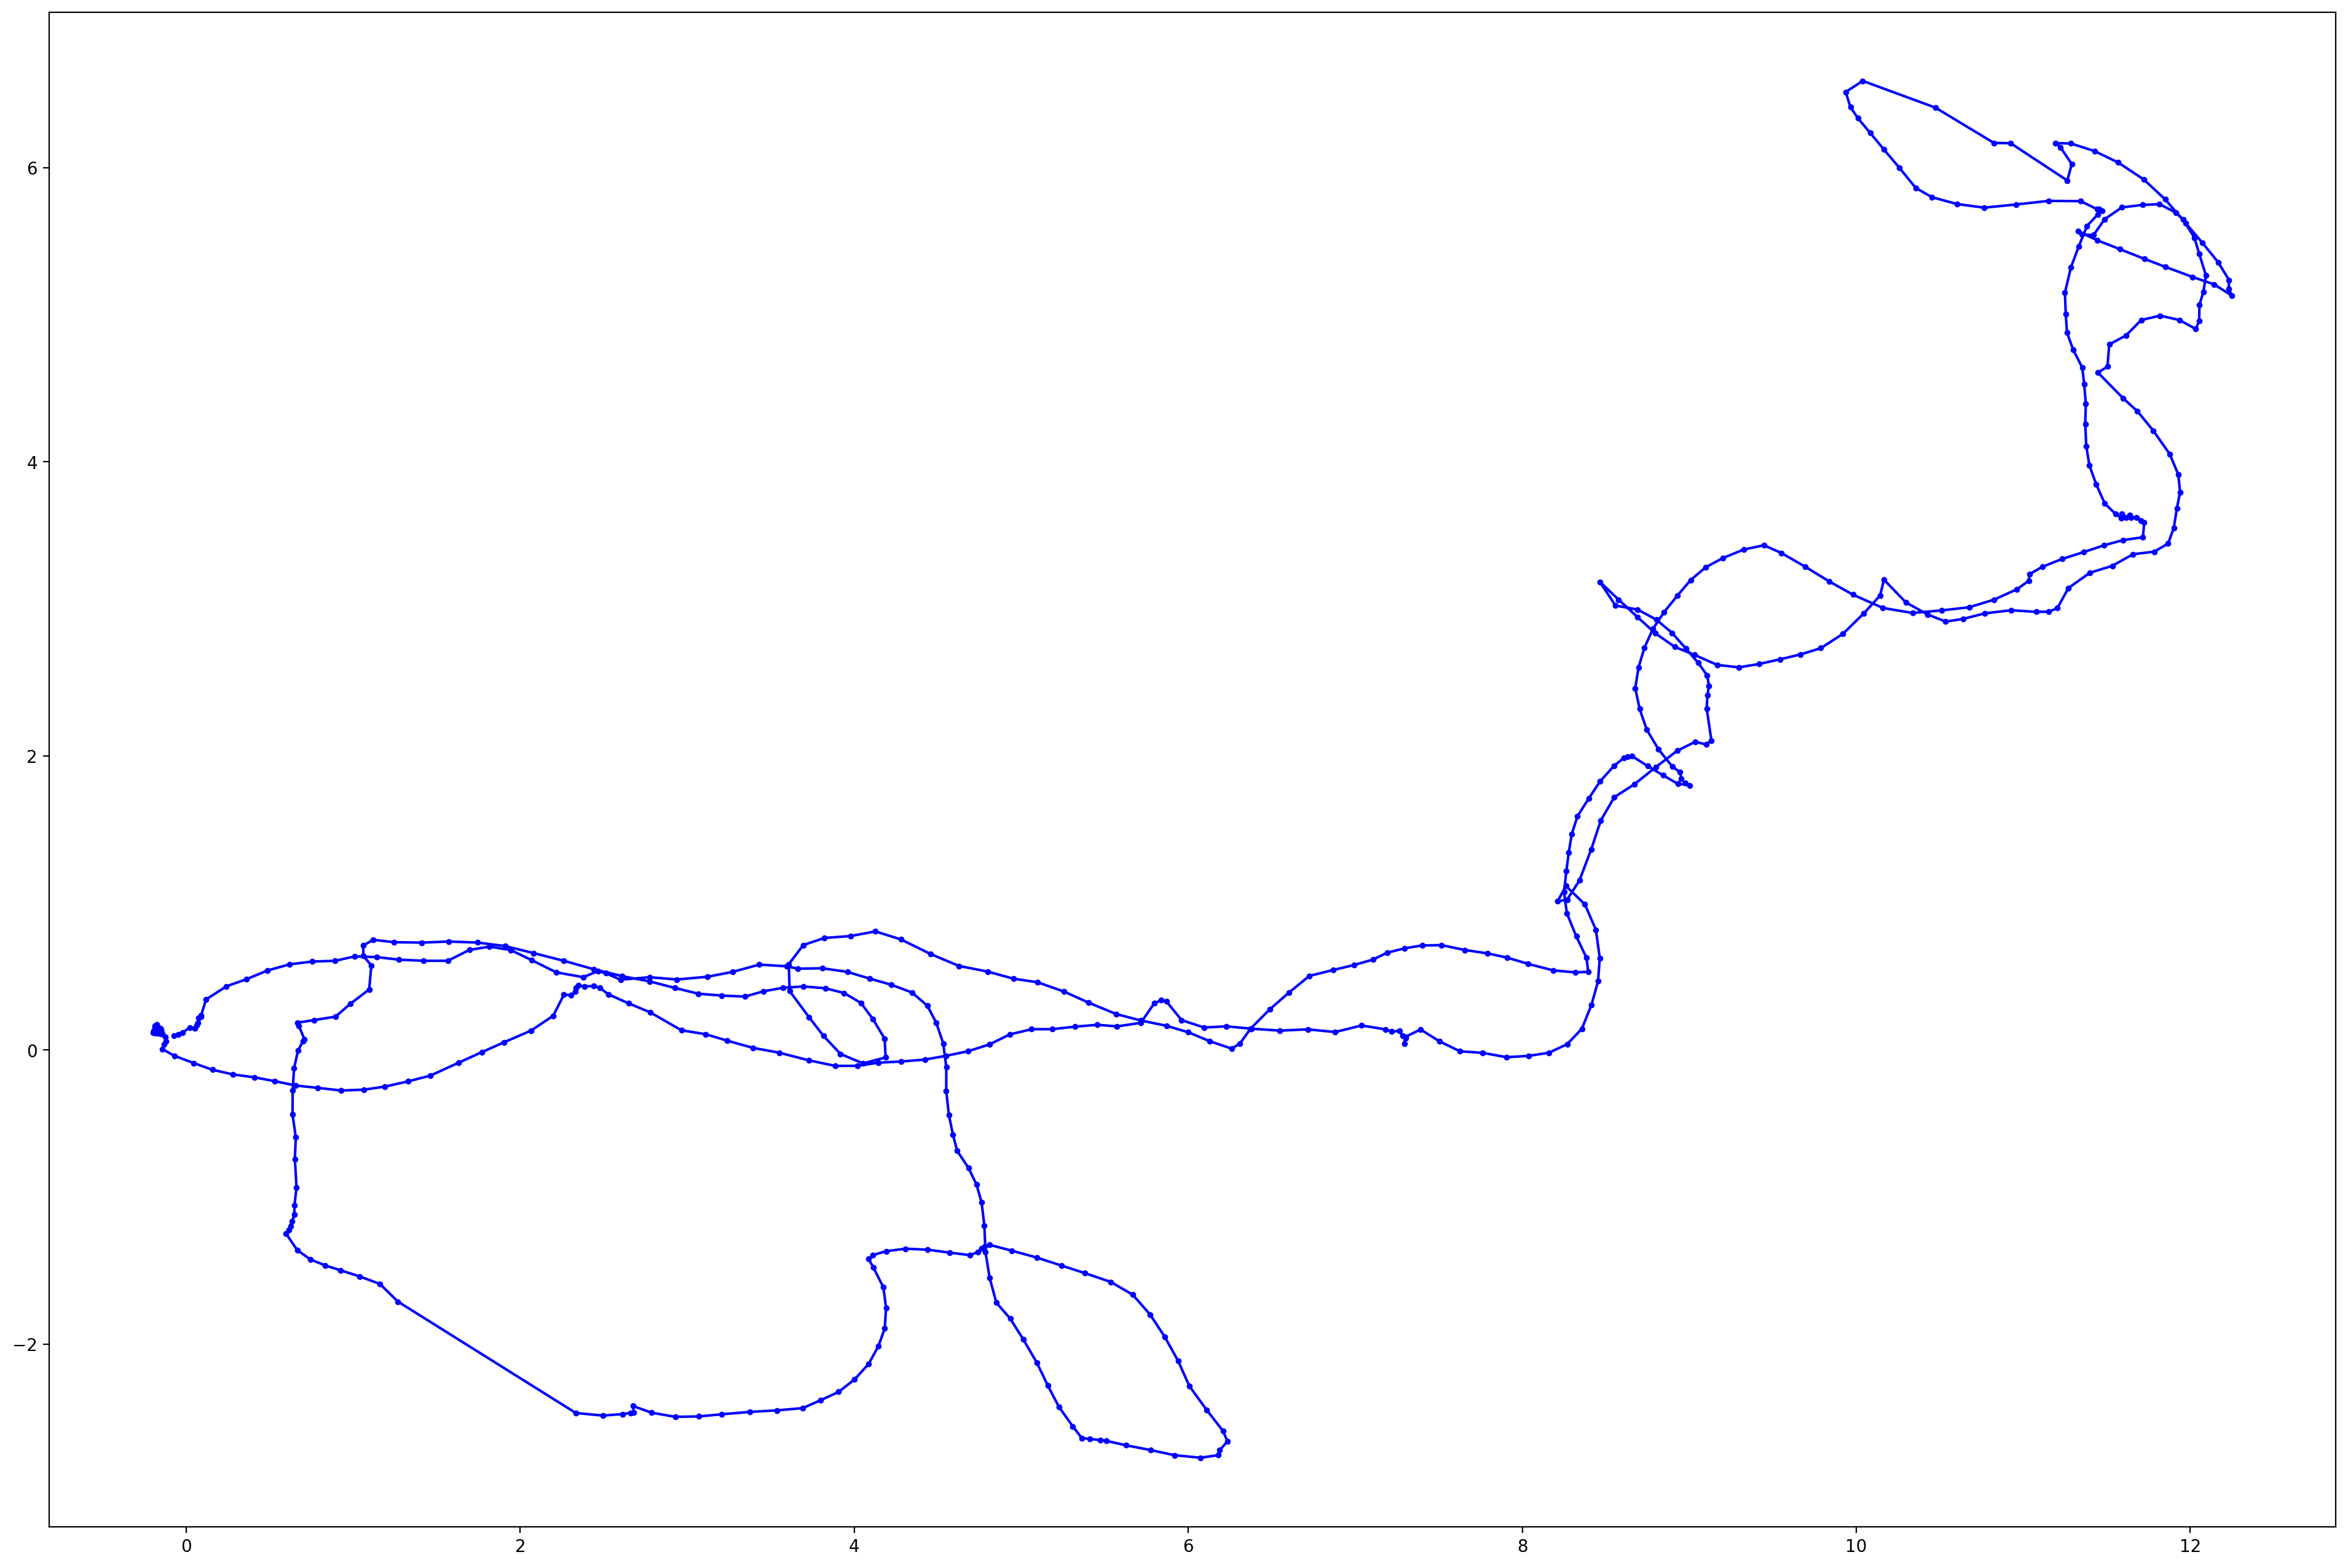

In [8]:
plt.figure(figsize=(24,16), dpi=200)
plt.plot(x[::31], y[::31], '-b.', markersize=5)
plt.show()

## Laser Scan Vs Point Cloud
*ls2pc* - converts ranges to their corresponding x,y coordinates


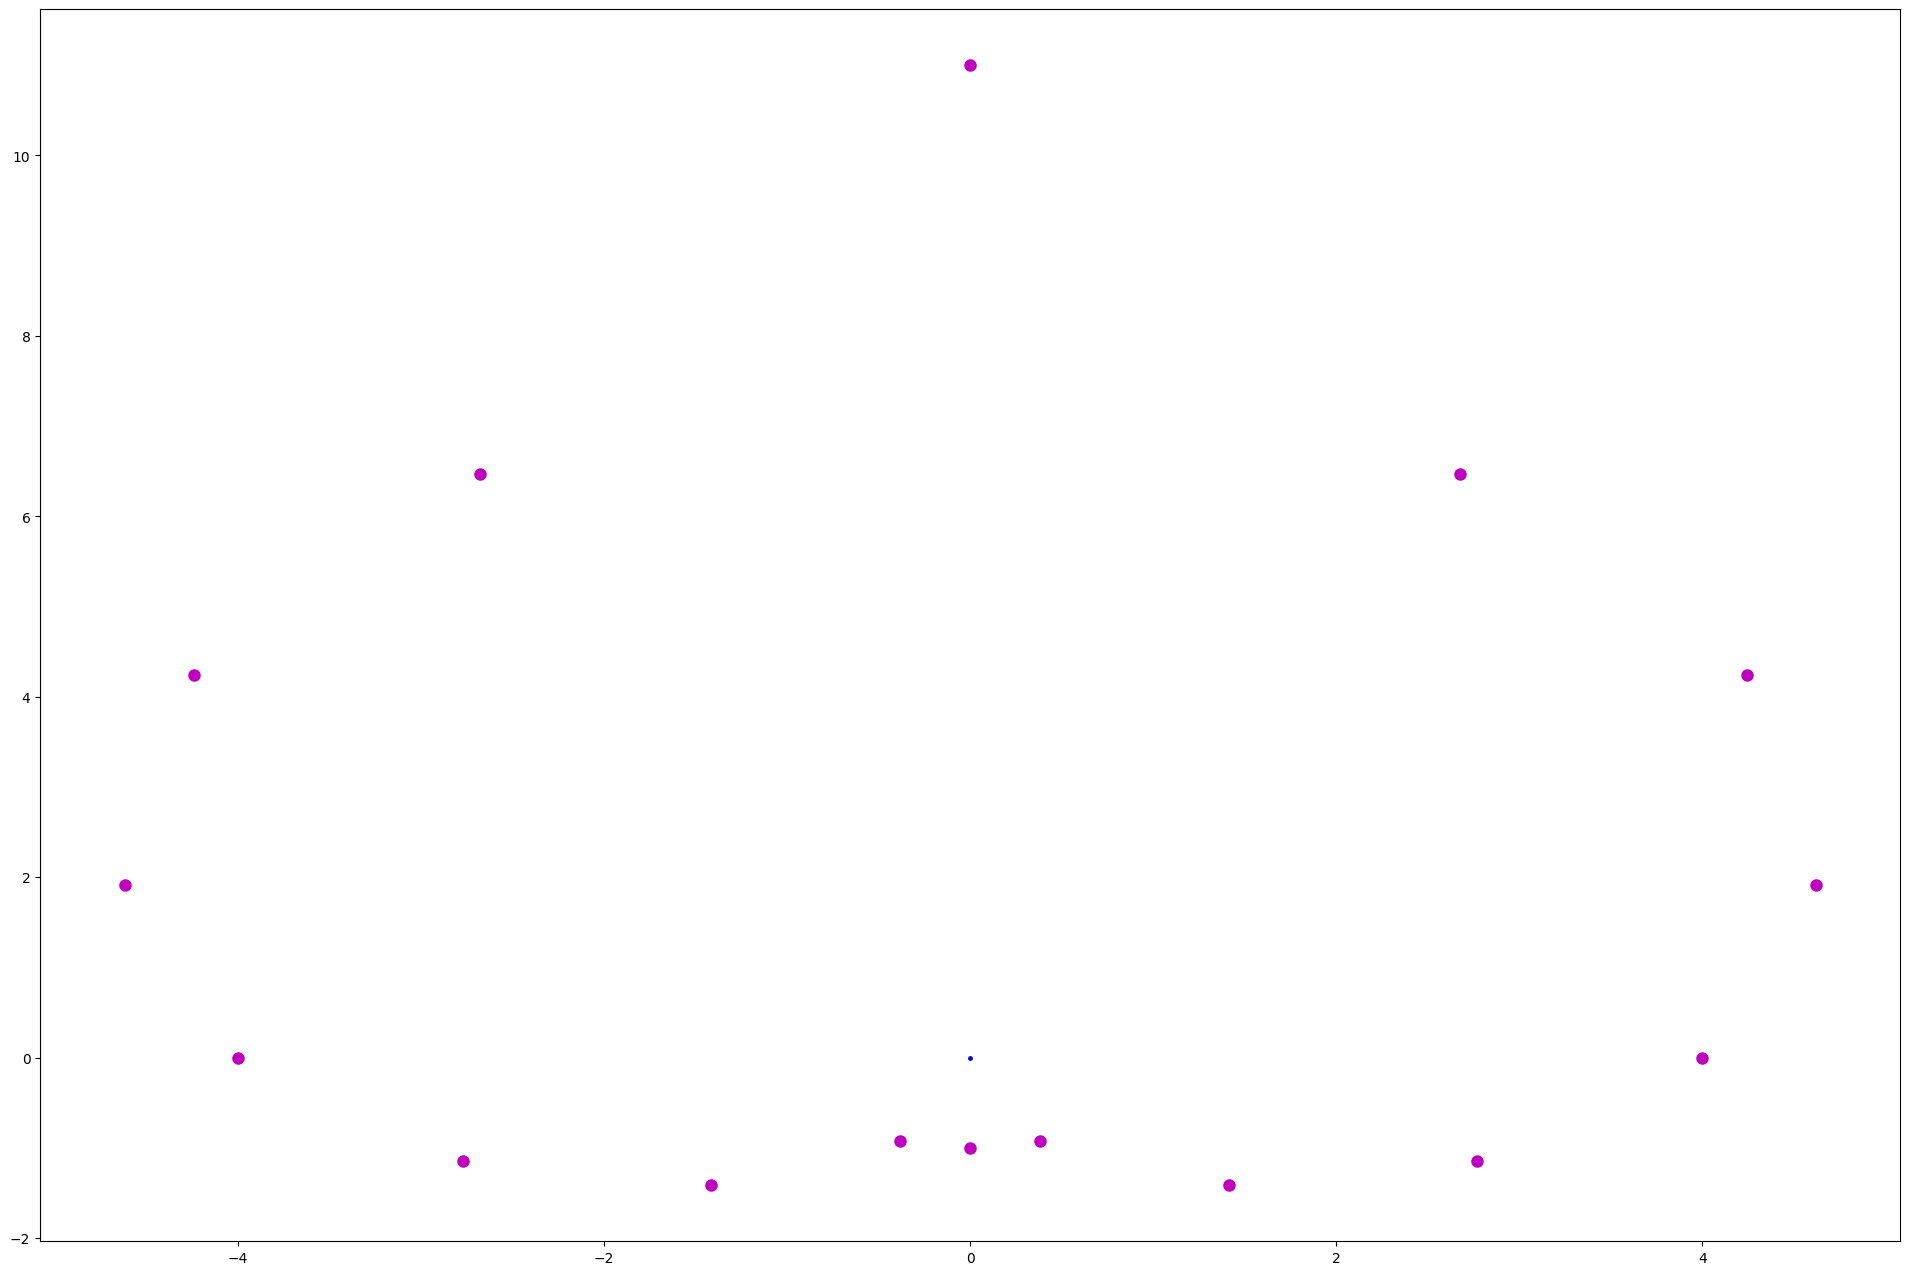

In [9]:
# This is a laser scan (LS) range array:
range_ = np.array([[1,1,2,3,4,5,6,7,11,7,6,5,4,3,2,1]])
# convert the LS to point cloud, using the information about the sensor orientations relative to each other:
x_origin = np.array([0])
y_origin = np.array([0])
yaw = np.array([0])

pc_x_r_, pc_y_r_, valid_inds_bool_, valid_inds_ = ls2pc(x_origin, y_origin, yaw, range_)

# plot the point cloud
plt.figure(figsize=(24,16), dpi=100)
plt.plot(pc_x_r_, pc_y_r_, 'm.', markersize=16)
plt.plot(0, 0, '-b.', markersize=5)
plt.show()

# play around with the other inputs of ls2pc: x_origin, y_origin, yaw.

## Add the laser scanner data


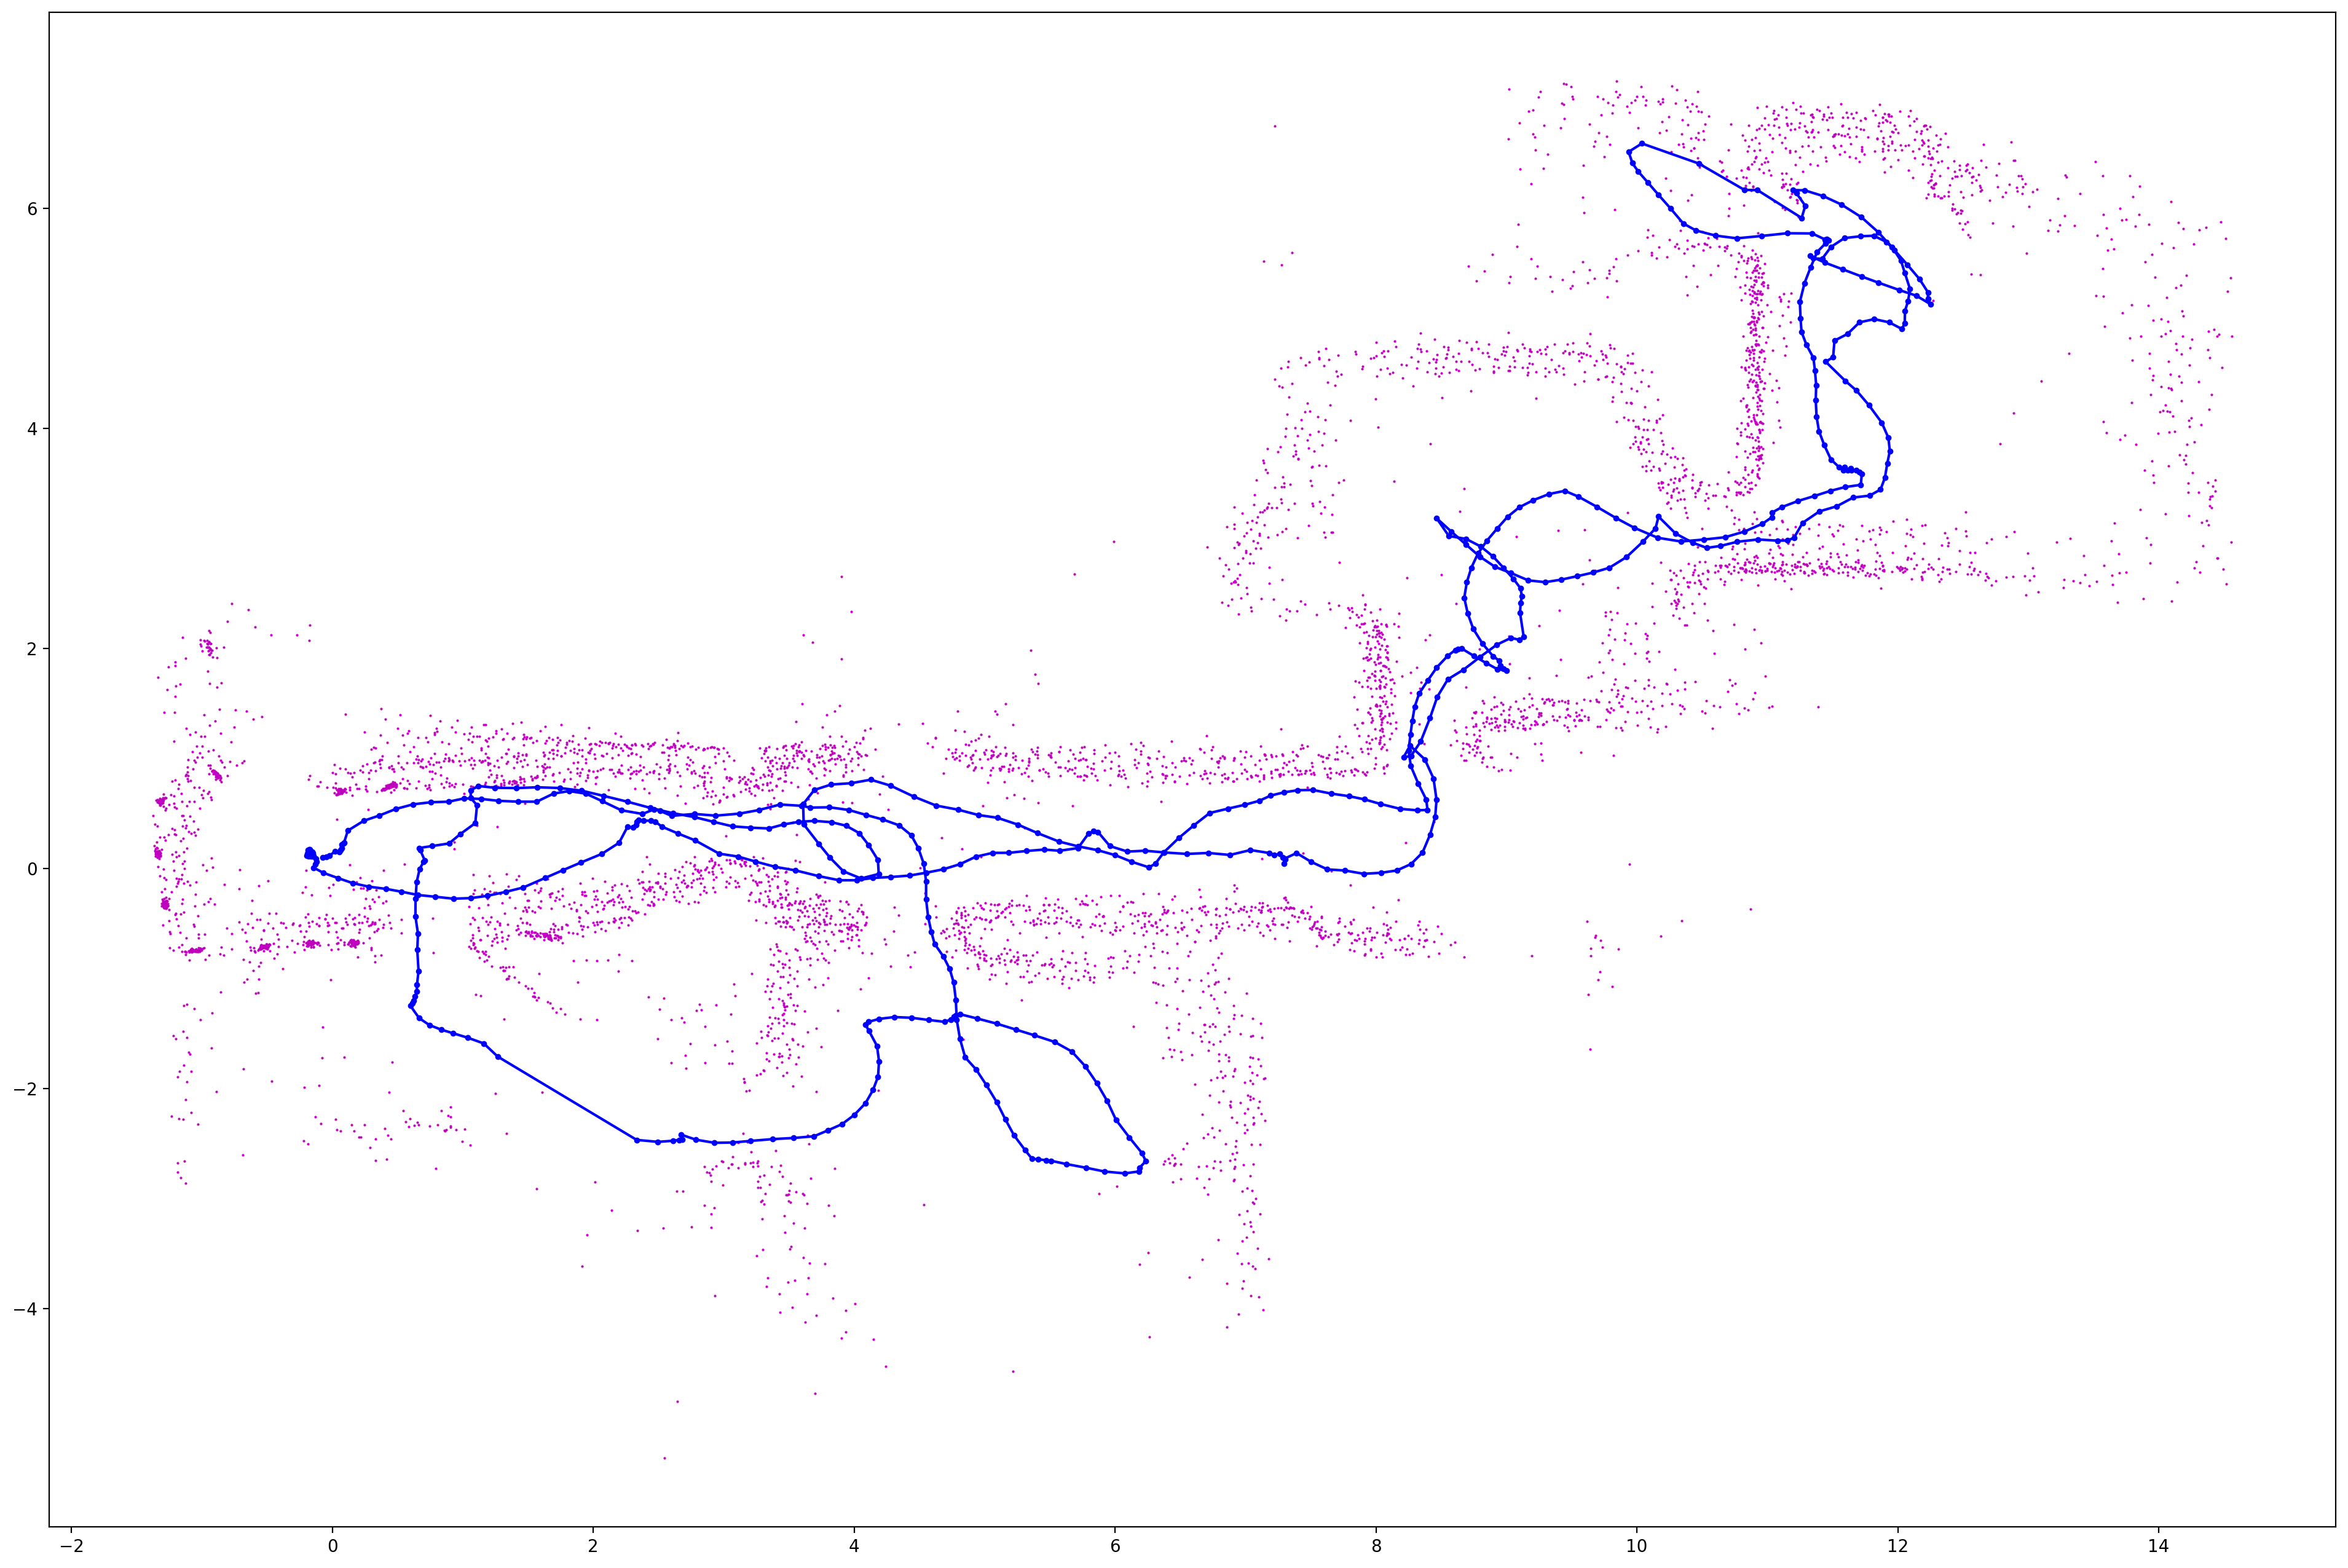

In [10]:
# Convert laser scan (16 ranges) to point cloud (2x16 xy coordinates)
pc_x_r_, pc_y_r_, valid_inds_bool_, valid_inds_ = ls2pc(x, y, t, ranges)
plt.figure(figsize=(24,16), dpi=200)
plt.plot(pc_x_r_[valid_inds_bool_][::31], pc_y_r_[valid_inds_bool_][::31], 'm.', markersize=1)
plt.plot(x[::31], y[::31], '-b.', markersize=5)
plt.show()

**What you see above is the same data ploted in the README.md**

In blue is the odometry - the xy coordinates of spot.

In magenta - the walls\objects picked up by the range sensors.

In [11]:
# convert laser scans to point cloud:
pc_x_r, pc_y_r, valid_inds_bool, valid_inds = ls2pc(x, y, t, ranges)

### Plot scene using plotly instead of pyplot:

In [13]:

mrkr = dict(color='LightSkyBlue', size=2,line=dict(color='MediumPurple', width=0.3))

fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(x=pc_x_r[valid_inds_bool][::11], y=pc_y_r[valid_inds_bool][::11], name='walls', mode='markers', marker_color=valid_inds[::11], marker=mrkr),
    row=1, col=1
)
# fig.add_trace(
#     go.Scatter(x=x[::31], y=y[::31], name='trj'),
#     row=1, col=1
# )
fig.add_trace(
    go.Scatter(x=x[::37], y=y[::37], name='trj', mode='markers', marker_color=np.arange(len(x))[::31], line=dict(width=1, color='DarkSlateGrey')),
    row=1, col=1
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
)
fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

The plot above uses *plotly* to show the recorded data.

Note that the color of all data changes as a function of time (temporally close measurements closly colored)

### Task
1. Add 2 markers colored green and red. The green indicating the starting position and the red indicating the final.
2. Change the color of the odometry marker to visualize what percent of the 16 range measurements are above 2 meters (e.g. black white gradient : 0%-blue, 100%-white).

In [14]:
# Enter your code here